In [1]:
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

from sklearn.preprocessing   import LabelEncoder , OneHotEncoder , StandardScaler , MinMaxScaler , Binarizer 
from sklearn.model_selection import train_test_split , GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve , roc_curve

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as ms
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# datasets



### 정밀도(precision)/재현율(recall) trade_off 
- sklearn Binarizer 클래스 fit_transform() 
- 임계값(threshold) 보다 크면 1 , 작으면 0 반환 

In [2]:
x = [[-1, -1, 2], 
     [2, 0, 0], 
     [0, 1.1, 1.2]]


In [4]:
holder = Binarizer(threshold=0.5) 
print(holder.fit_transform(x))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 1.]]


- predict_proba() : 개별 타켓(레이블)별 예측확률 값을 반환 받을 수 있다

In [7]:
titanic = pd.read_csv('./data/titanic_train.csv')
titanic

titanic_label =  titanic['Survived']
titanic_data  =  titanic.drop(['Survived'] , axis = 1)


In [8]:
# 레일블 인코딩 Cabin , Sex , Embarked
def drop_features(frm):
    frm.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return frm


def pre_processing(frm):
    frm['Age'].fillna(frm['Age'].mean(), inplace=True)
    frm['Cabin'].fillna('N', inplace=True)
    frm['Embarked'].fillna('N', inplace=True)
    return frm


def label_encoder(frm):
    frm['Cabin'] = frm['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        encoder = LabelEncoder()
        encoder.fit(frm[feature])
        frm[feature] = encoder.transform(frm[feature])
    return  frm

def transform_features(frm):
    frm = drop_features(frm)
    frm = pre_processing(frm)
    frm = label_encoder(frm)
    return frm

In [9]:
titanic_data_feature = transform_features(titanic_data)

In [10]:
titanic_data_feature

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,7.2500,7,3
1,1,0,38.000000,1,0,71.2833,2,0
2,3,0,26.000000,0,0,7.9250,7,3
3,1,0,35.000000,1,0,53.1000,2,3
4,3,1,35.000000,0,0,8.0500,7,3
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,7,3
887,1,0,19.000000,0,0,30.0000,1,3
888,3,0,29.699118,1,2,23.4500,7,3
889,1,1,26.000000,0,0,30.0000,2,0


In [11]:
def metrics_evaluation(y_test, y_pred) :
    print("정확도 : {} , 정밀도 : {} , 재현율 : {} , 조화평균(F1) : {}"
          .format(accuracy_score(y_test, y_pred) , 
                  precision_score(y_test, y_pred) , 
                  recall_score(y_test, y_pred) , 
                  f1_score(y_test, y_pred)))

In [12]:
X_train , X_test , y_train , y_test = train_test_split(titanic_data_feature , 
                                                       titanic_label , 
                                                       test_size = .2 , 
                                                       random_state = 10 ) 

In [14]:
logistic_model = LogisticRegression()
# 학습
logistic_model.fit(X_train , y_train)

LogisticRegression()

In [22]:
# 예측
y_pred = logistic_model.predict(X_test)

# 확률예측 값
y_pred_proba = logistic_model.predict_proba(X_test)


In [38]:
# y_pred_proba.shape
# y_pred_proba
# y_pred
# y_pred.shape

# 예측값과 예측확률 결과를 병합
pred_prob_result = np.concatenate( [y_pred_proba , y_pred.reshape(-1, 1)] , axis = 1)
pred_prob_result[ : 10]

array([[0.90642125, 0.09357875, 0.        ],
       [0.85371789, 0.14628211, 0.        ],
       [0.8771801 , 0.1228199 , 0.        ],
       [0.07331652, 0.92668348, 1.        ],
       [0.10645454, 0.89354546, 1.        ],
       [0.84935248, 0.15064752, 0.        ],
       [0.85619692, 0.14380308, 0.        ],
       [0.85752814, 0.14247186, 0.        ],
       [0.89740442, 0.10259558, 0.        ],
       [0.8618656 , 0.1381344 , 0.        ]])

In [36]:
metrics_evaluation(y_test , y_pred)

정확도 : 0.8268156424581006 , 정밀도 : 0.746031746031746 , 재현율 : 0.7580645161290323 , 조화평균(F1) : 0.752


In [53]:
user_th = 0.3
# y_pred_proba[ : ,  1].reshape(-1, 1)

y_pred_proba_01 = y_pred_proba[ : ,  1].reshape(-1, 1)
user_pred = Binarizer(threshold = user_th).fit_transform(y_pred_proba_01)
# user_pred

In [54]:
metrics_evaluation(y_test , user_pred)

정확도 : 0.7932960893854749 , 정밀도 : 0.6582278481012658 , 재현율 : 0.8387096774193549 , 조화평균(F1) : 0.7375886524822695


In [ ]:
- TPR(True Positive Rate)
   TP
-------
FN + TP

- TNR(True Negative Rate)
   TN
-------
TN + FP


In [64]:
pred_positive_label = logistic_model.predict_proba(X_test)[ :  , 1]
pred_positive_label

precision , recall , threshold = precision_recall_curve(y_test , pred_positive_label)
precision.shape , recall.shape , threshold.shape

((163,), (163,), (162,))

- 시각화(정밀도, 재현율이 임계값 변화데 따른 시각화)

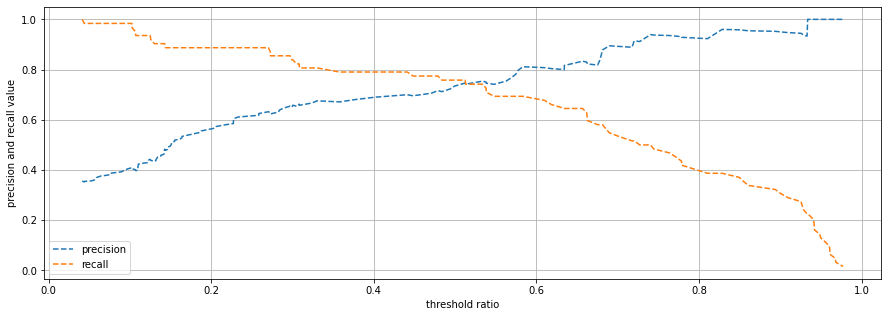

In [74]:
# 임계값이 1에 가까우면 TNR 커지고 FPR 작아진다

plt.figure(figsize=(15 , 5))

plt.plot(threshold , precision[ 0 : threshold.shape[0] ] , linestyle='--', label='precision')
plt.plot(threshold , recall[ 0 : threshold.shape[0] ] , linestyle='--', label='recall')

plt.xlabel('threshold ratio')
plt.ylabel('precision and recall value')
plt.legend()
plt.grid()

plt.show()
plt.close()

####  ROC AUC
- FPR(False Positive Rate) 변할 때 TPR이 어떻게 변하는지 

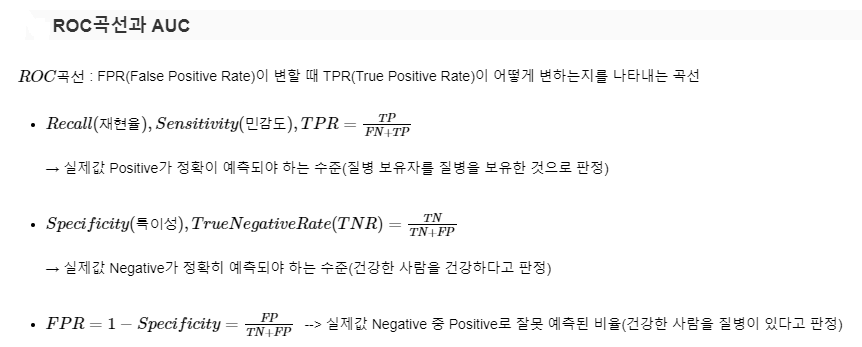

In [75]:
from IPython.display import Image
Image('c:\img/ROC-AUC.png' , width=700)

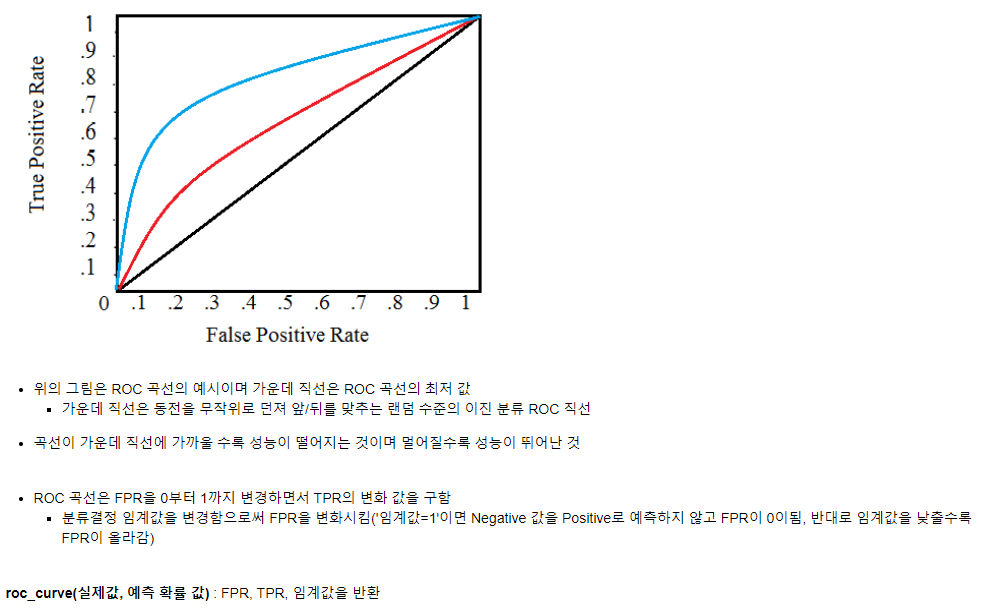

In [76]:
Image('c:\img/ROC-Curve.png' , width=700)

- 타이타닉을 이용한 생존자 예측 FPR , TPR , 임계값
- roc_curve(실제값 , 확률값)

In [85]:
pred_positive_label = logistic_model.predict_proba(X_test)[ : , 1 ]
# pred_positive_label.shape

fprs  ,tprs , thresholds = roc_curve(y_test , pred_positive_label)
# fprs.shape  ,tprs.shape , thresholds.shape

#  샘플 추출
thr_idx = np.arange(1, thresholds.shape[0] , 6) 
thr_idx
# thresholds[thr_idx]
# fprs[thr_idx] 
# tprs[thr_idx]

array([ 1,  7, 13, 19, 25, 31, 37, 43, 49, 55])

In [86]:
thresholds[thr_idx]

array([0.97705291, 0.72696136, 0.65654307, 0.5120958 , 0.3304279 ,
       0.29711527, 0.18758072, 0.12499306, 0.109969  , 0.02692116])

In [87]:
fprs[thr_idx] 

array([0.        , 0.02564103, 0.06837607, 0.13675214, 0.20512821,
       0.23931624, 0.37606838, 0.62393162, 0.72649573, 1.        ])

In [88]:
tprs[thr_idx]

array([0.01612903, 0.5       , 0.64516129, 0.75806452, 0.80645161,
       0.85483871, 0.88709677, 0.93548387, 0.93548387, 1.        ])

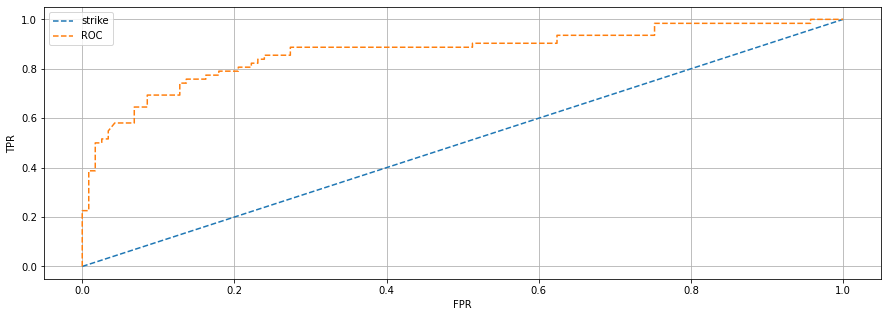

In [92]:
plt.figure(figsize=(15 , 5))

plt.plot([0,1] , [0,1] , linestyle='--', label='strike')

plt.plot(fprs , tprs ,   linestyle='--', label='ROC')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.grid()

plt.show()
plt.close()

In [103]:
# AUC 성능평가 확인

def metrics_evaluation(y_test, y_pred) :
    print("정확도 : {} , 정밀도 : {} , 재현율 : {} , 조화평균(F1) : {} , AUC : {} "
          .format(accuracy_score(y_test, y_pred) , 
                  precision_score(y_test, y_pred) , 
                  recall_score(y_test, y_pred) , 
                  f1_score(y_test, y_pred) , 
                  roc_auc_score(y_test, y_pred) ) )

In [105]:
metrics_evaluation(y_test , y_pred)

정확도 : 0.8268156424581006 , 정밀도 : 0.746031746031746 , 재현율 : 0.7580645161290323 , 조화평균(F1) : 0.752 , AUC : 0.8106561896884479 
